# ДЗ 2

В этом задании нужно будет обучить архитектуру для задачи Image Classification. Вам нужно будет реализовать архитектуру, обучить ее, а так же выполнить некоторые дополнительные задания.

В качестве датасета будет использовать вот этот - https://www.kaggle.com/datasets/slothkong/10-monkey-species

### Imports

In [3]:
# !pip install pytorch_lightning

In [2]:
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torchvision
import torchvision.models as models
import pytorch_lightning as pl
import torch.nn as nn
from torchmetrics import Accuracy
import torch.optim as optim
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from collections import Counter
import torch.nn.functional as F
import os
import sys
import albumentations as A
from albumentations.pytorch import ToTensorV2
import copy
import random
import cv2
import fnmatch
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from torch.optim import lr_scheduler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sn
import pandas as pd

### Task

Реализуйте VGG16 from scratch. Чтобы вспомнить архитектуру, обратитесь к лекции + оригинальной статье авторов+google.

Если хотите реализовать что-то поинтереснее (resnet, ViT???) - делайте, будет учтено.

Что будет оцениваться в задании:
* VGG16 from scratch **6 баллов**
* добавьте аугментаций, напишите краткое саммари почему выбрали именно такой набор аугментаций. **1 балл**
* дописать логику обучения модели **2 балла**
* дописать логику тестирования модели **1 балл**
* возьмите еще 2 модели из зоопарка моделей [torchvision](https://pytorch.org/vision/stable/models.html?), зафайнтюньте на наш датасет. Сравните их между собой и вашей реализацией. **4 балла**
* обязательно в конце напишите общий отчет о проделанной работе. Для лучшей модели проведите анализ метрик и ошибок, постройте confusion_matrix и classification report **2 балла**
* графики обучения обязательно должны присутсвовать

**NOTE**: рядом лежит ноутбук с baseline solution, вы можете отталкиваться от него, если хотите.

## VGG

### VGG16

In [3]:
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()) # b_s x 3 x 512 x 512 -> b_s x 64 x 512 x 512
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2)) # b_s x 64 x 512 x 512 -> b_s x 64 x 256 x 256
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()) # b_s x 64 x 256 x 256 -> b_s x 128 x 256 x 256
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)) # b_s x 128 x 256 x 256 -> b_s x 128 x 128 x 128
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()) # b_s x 128 x 128 x 128 -> b_s x 256 x 128 x 128
        
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)) # b_s x 256 x 128 x 128 -> b_s x 256 x 64 x 64
        
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()) # b_s x 256 x 64 x 64 -> b_s x 512 x 64 x 64
        
        self.layer8 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)) # b_s x 512 x 64 x 64 -> b_s x 512 x 32 x 32
        
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)) # b_s x 512 x 32 x 32 -> b_s x 512 x 16 x 16
        
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)) # b_s x 512 x 16 x 16 -> b_s x 1024 x 8 x 8

        self.layer11 = nn.Sequential(
            nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)) # b_s x 1024 x 8 x 8 -> b_s x 1024 x 4 x 4
        
        self.layer12 = nn.Sequential(
            nn.Conv2d(1024, 1024, kernel_size=4, stride=1, padding=0)) # b_s x 1024 x 4 x 4 -> b_s x 1024 x 1 x 1
        
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.ReLU())
        
        self.fc2= nn.Linear(1024, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [4]:
def weights_init_uniform(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

### Augmentations
Я выбрала такие аугментации, чтобы модель была устойчива к поворотам и сдвигам объектов, а также к разной яркости и контрастности изображений.

In [5]:
train_transform = A.Compose([
    A.Resize(512,512),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
    ])

val_transform = A.Compose([
    A.Resize(512,512),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
    ])

### Dataset

In [5]:
# !unzip 'monkeys.zip'

In [6]:
def get_imgs_filepaths(main_folder):
    paths = []
    for i in range(10):
        folder = os.path.join(main_folder, 'n'+str(i)+'/')
        listOfFiles = os.listdir(folder) 
        img_pattern = '*.jpg'
        for entry in listOfFiles:
            if fnmatch.fnmatch(entry, img_pattern):
                paths.append(os.path.join(folder, entry))
    return paths

train_folder = './training/training/'
val_folder = './validation/validation/'

train_paths = get_imgs_filepaths(train_folder)
val_paths = get_imgs_filepaths(val_folder)

In [7]:
class MonkeysDataset(Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = float(self.images_filepaths[idx].split('/')[3][1])
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, label

In [8]:
train_dataset = MonkeysDataset(train_paths, train_transform)
val_dataset = MonkeysDataset(val_paths, val_transform)

### Check number of classes and samples

In [10]:
PATH_train = './training/training'
PATH_val = './validation/validation'

train_ds = ImageFolder('./training/training/',transform=train_transform)
test_ds = ImageFolder('./validation/validation/',transform=val_transform)

In [11]:
train_cnt = Counter(train_ds.targets)
test_cnt = Counter(test_ds.targets)
print(train_cnt)
print(test_cnt)

Counter({3: 122, 7: 114, 5: 113, 1: 111, 2: 110, 6: 106, 8: 106, 0: 105, 4: 105, 9: 105})
Counter({3: 30, 1: 28, 5: 28, 7: 28, 2: 27, 8: 27, 0: 26, 4: 26, 6: 26, 9: 26})


### Dataloader

In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

In [11]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = train_transform = A.Compose([ A.Resize(224,224),
                                                      A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=45, p=0.5),
                                                      A.RandomBrightnessContrast(p=0.5),
                                                    ])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

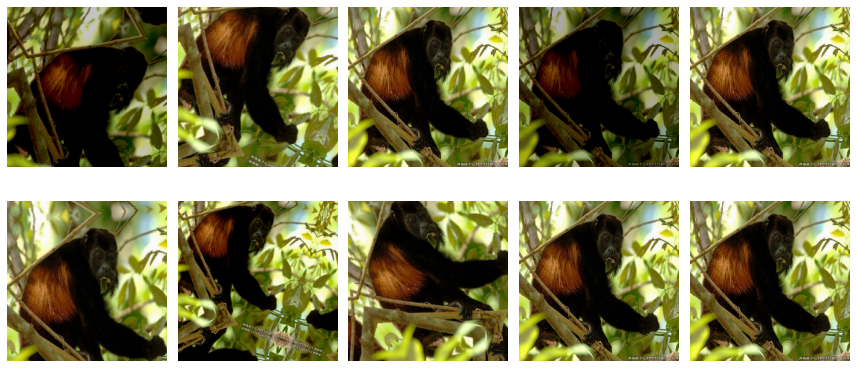

In [14]:
random.seed(42)
visualize_augmentations(train_dataset)

### Train
Выберем, что хотим сохранять в истории обучения: 


*   loss для обеих выборок (train, val)
*   accuracy 
*   F1-score + weighted agerage по классам

каждые every_epoch эпох



In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [11]:
def count_accuracy(true, pred):
    pred = torch.argmax(pred, dim=1).cpu().detach().numpy()
    true = true.cpu().detach().numpy()
    return accuracy_score(true, pred)

def count_f1(true, pred):
    pred = torch.argmax(pred, dim=1).cpu().detach().numpy()
    true = true.cpu().detach().numpy()
    return f1_score(true, pred, average='weighted')

In [12]:
def train_model(model, weights_folder, optimizer, loss_func, scheduler, num_epochs=40, every_epoch=5):
    
    train_history = {
        'loss': [],
        'accuracy': [],
        'f1': []
    }
    val_history = {
        'loss': [],
        'accuracy': [],
        'f1': []
    }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0

    for epoch in range(1, num_epochs + 1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)
        
        # TRAIN
        print("PHASE: TRAIN")
        scheduler.step()
        for param_group in optimizer.param_groups:
            print("LR", param_group['lr'])

        epoch_loss = 0
        epoch_accuracy = 0
        epoch_f1 = 0

        model.train()  # Set model to training mode

        for inputs, labels in tqdm(train_dataloader):
            inputs = inputs.float() 
            inputs = inputs.to(device)
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            accuracy = count_accuracy(labels, outputs)
            f1 = count_f1(labels, outputs)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.cpu().item()
            epoch_accuracy += accuracy
            epoch_f1 += f1

        if epoch % every_epoch == 0:
            epoch_loss /= len(train_dataloader)
            epoch_accuracy /= len(train_dataloader)
            epoch_f1 /= len(train_dataloader)
            train_history['loss'].append(epoch_loss)
            train_history['accuracy'].append(epoch_accuracy)
            train_history['f1'].append(epoch_f1)
            print("train_loss: ", epoch_loss)
            print("train_accuracy: ", epoch_accuracy)
            print("train_f1: ", epoch_f1)
            print("---------------------------")
        
        # VAL
        print("PHASE: VAL")
        model.eval()
        epoch_loss = 0
        epoch_accuracy = 0
        epoch_f1 = 0
        
        for inputs, labels in tqdm(val_dataloader):
            inputs=inputs.float() 
            inputs = inputs.to(device)
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)
            
            with torch.no_grad():
                outputs = model(inputs)
            
            loss = loss_func(outputs, labels)
            accuracy = count_accuracy(labels, outputs)
            f1 = count_f1(labels, outputs)

            epoch_loss += loss.cpu().item()
            epoch_accuracy += accuracy
            epoch_f1 += f1
        
        if epoch % every_epoch == 0:
            epoch_loss /= len(val_dataloader)
            epoch_accuracy /= len(val_dataloader)
            epoch_f1 /= len(val_dataloader)
            val_history['loss'].append(epoch_loss)
            val_history['accuracy'].append(epoch_accuracy)
            val_history['f1'].append(epoch_f1)
            print("val_loss: ", epoch_loss)
            print("val_accuracy: ", epoch_accuracy)
            print("val_f1: ", epoch_f1)
            print("---------------------------")
            
            if epoch_f1 > best_f1:
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, os.path.join(weights_folder, 'best_weights_'+str(epoch)+'.pkl'))   
                best_f1 = epoch_f1
        
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_history, val_history

In [16]:
model = VGG16()
model.apply(weights_init_uniform)

model.to(device)
None

In [17]:
train_params = {
    'start_lr': 1e-5,
    'scheduler_step_size': 10,
    'scheduler_gamma': 0.5,
    'num_epochs': 60,
    'every_epoch': 2,
}

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                          lr=train_params['start_lr'])

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, 
                                       step_size=train_params['scheduler_step_size'], 
                                       gamma=train_params['scheduler_gamma'])
loss_func = nn.CrossEntropyLoss()

model, train_history, val_history = train_model(model, 'vgg_weights', optimizer_ft, 
                                                loss_func, exp_lr_scheduler, 
                                                num_epochs=train_params['num_epochs'],
                                                every_epoch = train_params['every_epoch'])

/home/user/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch 1/60
----------
PHASE: TRAIN
LR 1e-05


100%|██████████| 137/137 [00:15<00:00,  8.61it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.82it/s]


Epoch 2/60
----------
PHASE: TRAIN
LR 1e-05


100%|██████████| 137/137 [00:16<00:00,  8.35it/s]


train_loss:  1.6213297186976803
train_accuracy:  0.4562043795620438
train_f1:  0.44280500521376454
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.76it/s]


val_loss:  1.3958075896782034
val_accuracy:  0.5220588235294118
val_f1:  0.6172690259087318
---------------------------
Epoch 3/60
----------
PHASE: TRAIN
LR 1e-05


100%|██████████| 137/137 [00:16<00:00,  8.48it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.15it/s]


Epoch 4/60
----------
PHASE: TRAIN
LR 1e-05


100%|██████████| 137/137 [00:16<00:00,  8.50it/s]


train_loss:  1.2218439772616339
train_accuracy:  0.5958029197080292
train_f1:  0.598757386166145
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.89it/s]


val_loss:  1.0225912899819805
val_accuracy:  0.6139705882352942
val_f1:  0.7228354978354979
---------------------------
Epoch 5/60
----------
PHASE: TRAIN
LR 1e-05


100%|██████████| 137/137 [00:15<00:00,  8.60it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.91it/s]


Epoch 6/60
----------
PHASE: TRAIN
LR 1e-05


100%|██████████| 137/137 [00:16<00:00,  8.42it/s]


train_loss:  0.9829645872551159
train_accuracy:  0.6624087591240876
train_f1:  0.6694169273548836
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.96it/s]


val_loss:  0.9218488440794104
val_accuracy:  0.6985294117647058
val_f1:  0.7792326954091662
---------------------------
Epoch 7/60
----------
PHASE: TRAIN
LR 1e-05


100%|██████████| 137/137 [00:16<00:00,  8.48it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.74it/s]


Epoch 8/60
----------
PHASE: TRAIN
LR 1e-05


100%|██████████| 137/137 [00:16<00:00,  8.51it/s]


train_loss:  0.8404792917035792
train_accuracy:  0.7235401459854015
train_f1:  0.7299878345498784
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.90it/s]


val_loss:  0.7268985352369354
val_accuracy:  0.7536764705882353
val_f1:  0.8459243575052402
---------------------------
Epoch 9/60
----------
PHASE: TRAIN
LR 1e-05


100%|██████████| 137/137 [00:16<00:00,  8.52it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.79it/s]


Epoch 10/60
----------
PHASE: TRAIN
LR 5e-06


100%|██████████| 137/137 [00:16<00:00,  8.48it/s]


train_loss:  0.5820095513532632
train_accuracy:  0.7883211678832117
train_f1:  0.7913429787973584
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.97it/s]


val_loss:  0.653319013551535
val_accuracy:  0.7904411764705882
val_f1:  0.8676002510561336
---------------------------
Epoch 11/60
----------
PHASE: TRAIN
LR 5e-06


100%|██████████| 137/137 [00:15<00:00,  8.77it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.05it/s]


Epoch 12/60
----------
PHASE: TRAIN
LR 5e-06


100%|██████████| 137/137 [00:16<00:00,  8.54it/s]


train_loss:  0.48460102244450226
train_accuracy:  0.8266423357664233
train_f1:  0.8372393117831075
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.04it/s]


val_loss:  0.6440900694613125
val_accuracy:  0.8051470588235294
val_f1:  0.8768969184410362
---------------------------
Epoch 13/60
----------
PHASE: TRAIN
LR 5e-06


100%|██████████| 137/137 [00:15<00:00,  8.75it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.17it/s]


Epoch 14/60
----------
PHASE: TRAIN
LR 5e-06


100%|██████████| 137/137 [00:15<00:00,  8.64it/s]


train_loss:  0.4264888905369452
train_accuracy:  0.843978102189781
train_f1:  0.8505735140771635
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.31it/s]


val_loss:  0.6451697973089348
val_accuracy:  0.7977941176470589
val_f1:  0.8708679392502924
---------------------------
Epoch 15/60
----------
PHASE: TRAIN
LR 5e-06


100%|██████████| 137/137 [00:16<00:00,  8.37it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.84it/s]


Epoch 16/60
----------
PHASE: TRAIN
LR 5e-06


100%|██████████| 137/137 [00:15<00:00,  8.62it/s]


train_loss:  0.35446412794727045
train_accuracy:  0.885036496350365
train_f1:  0.8950186826555443
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.79it/s]


val_loss:  0.5794692311028484
val_accuracy:  0.8088235294117647
val_f1:  0.879586263409793
---------------------------
Epoch 17/60
----------
PHASE: TRAIN
LR 5e-06


100%|██████████| 137/137 [00:17<00:00,  8.04it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.95it/s]


Epoch 18/60
----------
PHASE: TRAIN
LR 5e-06


100%|██████████| 137/137 [00:16<00:00,  8.31it/s]


train_loss:  0.34731305155386455
train_accuracy:  0.8905109489051095
train_f1:  0.8941721700845792
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.33it/s]


val_loss:  0.6454095436929492
val_accuracy:  0.7830882352941176
val_f1:  0.8639174959027902
---------------------------
Epoch 19/60
----------
PHASE: TRAIN
LR 5e-06


100%|██████████| 137/137 [00:16<00:00,  8.45it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.98it/s]


Epoch 20/60
----------
PHASE: TRAIN
LR 2.5e-06


100%|██████████| 137/137 [00:15<00:00,  8.66it/s]


train_loss:  0.25992741460238933
train_accuracy:  0.916058394160584
train_f1:  0.9257871335882287
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.12it/s]


val_loss:  0.5510608232032288
val_accuracy:  0.8088235294117647
val_f1:  0.8815708392914277
---------------------------
Epoch 21/60
----------
PHASE: TRAIN
LR 2.5e-06


100%|██████████| 137/137 [00:15<00:00,  8.76it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.94it/s]


Epoch 22/60
----------
PHASE: TRAIN
LR 2.5e-06


100%|██████████| 137/137 [00:15<00:00,  8.66it/s]


train_loss:  0.21048622201774678
train_accuracy:  0.9297445255474452
train_f1:  0.9329292665971499
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.99it/s]


val_loss:  0.6066518742749502
val_accuracy:  0.8051470588235294
val_f1:  0.8784762622997918
---------------------------
Epoch 23/60
----------
PHASE: TRAIN
LR 2.5e-06


100%|██████████| 137/137 [00:16<00:00,  8.50it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.15it/s]


Epoch 24/60
----------
PHASE: TRAIN
LR 2.5e-06


100%|██████████| 137/137 [00:15<00:00,  8.67it/s]


train_loss:  0.181229810488757
train_accuracy:  0.958029197080292
train_f1:  0.9625304136253044
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.84it/s]


val_loss:  0.5791399064739167
val_accuracy:  0.8161764705882353
val_f1:  0.8856336882072178
---------------------------
Epoch 25/60
----------
PHASE: TRAIN
LR 2.5e-06


100%|██████████| 137/137 [00:15<00:00,  9.00it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.15it/s]


Epoch 26/60
----------
PHASE: TRAIN
LR 2.5e-06


100%|██████████| 137/137 [00:15<00:00,  8.60it/s]


train_loss:  0.1601808935091117
train_accuracy:  0.9571167883211679
train_f1:  0.961022766770942
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.07it/s]


val_loss:  0.5232939626028597
val_accuracy:  0.8125
val_f1:  0.8833676943971063
---------------------------
Epoch 27/60
----------
PHASE: TRAIN
LR 2.5e-06


100%|██████████| 137/137 [00:15<00:00,  8.74it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.90it/s]


Epoch 28/60
----------
PHASE: TRAIN
LR 2.5e-06


100%|██████████| 137/137 [00:15<00:00,  8.69it/s]


train_loss:  0.16255119153346023
train_accuracy:  0.9525547445255474
train_f1:  0.956830031282586
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.85it/s]


val_loss:  0.5764470710932715
val_accuracy:  0.8088235294117647
val_f1:  0.880476100696689
---------------------------
Epoch 29/60
----------
PHASE: TRAIN
LR 2.5e-06


100%|██████████| 137/137 [00:16<00:00,  8.32it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.65it/s]


Epoch 30/60
----------
PHASE: TRAIN
LR 1.25e-06


100%|██████████| 137/137 [00:16<00:00,  8.40it/s]


train_loss:  0.14244885549601846
train_accuracy:  0.9607664233576643
train_f1:  0.9629147312541474
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.90it/s]


val_loss:  0.6063684577759832
val_accuracy:  0.7977941176470589
val_f1:  0.8732549721520312
---------------------------
Epoch 31/60
----------
PHASE: TRAIN
LR 1.25e-06


100%|██████████| 137/137 [00:16<00:00,  8.16it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.06it/s]


Epoch 32/60
----------
PHASE: TRAIN
LR 1.25e-06


100%|██████████| 137/137 [00:16<00:00,  8.45it/s]


train_loss:  0.13713594082824504
train_accuracy:  0.9625912408759124
train_f1:  0.9649953655428106
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.74it/s]


val_loss:  0.5465473182780175
val_accuracy:  0.8272058823529411
val_f1:  0.8927403070785426
---------------------------
Epoch 33/60
----------
PHASE: TRAIN
LR 1.25e-06


100%|██████████| 137/137 [00:15<00:00,  8.69it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.02it/s]


Epoch 34/60
----------
PHASE: TRAIN
LR 1.25e-06


100%|██████████| 137/137 [00:15<00:00,  8.76it/s]


train_loss:  0.12193254289645565
train_accuracy:  0.968065693430657
train_f1:  0.9722019464720194
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.10it/s]


val_loss:  0.5773128929885227
val_accuracy:  0.8198529411764706
val_f1:  0.884834732261203
---------------------------
Epoch 35/60
----------
PHASE: TRAIN
LR 1.25e-06


100%|██████████| 137/137 [00:16<00:00,  8.20it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.13it/s]


Epoch 36/60
----------
PHASE: TRAIN
LR 1.25e-06


100%|██████████| 137/137 [00:15<00:00,  8.75it/s]


train_loss:  0.11135524757423976
train_accuracy:  0.9671532846715328
train_f1:  0.9681873479318736
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.67it/s]


val_loss:  0.5585306002672844
val_accuracy:  0.8235294117647058
val_f1:  0.8900563488798783
---------------------------
Epoch 37/60
----------
PHASE: TRAIN
LR 1.25e-06


100%|██████████| 137/137 [00:16<00:00,  8.55it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.01it/s]


Epoch 38/60
----------
PHASE: TRAIN
LR 1.25e-06


100%|██████████| 137/137 [00:16<00:00,  8.37it/s]


train_loss:  0.1148619931191206
train_accuracy:  0.968065693430657
train_f1:  0.9716602942880315
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.01it/s]


val_loss:  0.5728648954254287
val_accuracy:  0.8051470588235294
val_f1:  0.8768708823855884
---------------------------
Epoch 39/60
----------
PHASE: TRAIN
LR 1.25e-06


100%|██████████| 137/137 [00:15<00:00,  8.89it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.07it/s]


Epoch 40/60
----------
PHASE: TRAIN
LR 6.25e-07


100%|██████████| 137/137 [00:16<00:00,  8.48it/s]


train_loss:  0.10198149951446774
train_accuracy:  0.9735401459854015
train_f1:  0.9787017726798749
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.23it/s]


val_loss:  0.530522867828361
val_accuracy:  0.8308823529411765
val_f1:  0.8948923217305571
---------------------------
Epoch 41/60
----------
PHASE: TRAIN
LR 6.25e-07


100%|██████████| 137/137 [00:16<00:00,  8.49it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.98it/s]


Epoch 42/60
----------
PHASE: TRAIN
LR 6.25e-07


100%|██████████| 137/137 [00:15<00:00,  8.75it/s]


train_loss:  0.08995162286408191
train_accuracy:  0.9863138686131386
train_f1:  0.987287104622871
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.90it/s]


val_loss:  0.5182252718214466
val_accuracy:  0.8272058823529411
val_f1:  0.8937505713241009
---------------------------
Epoch 43/60
----------
PHASE: TRAIN
LR 6.25e-07


100%|██████████| 137/137 [00:15<00:00,  8.71it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.82it/s]


Epoch 44/60
----------
PHASE: TRAIN
LR 6.25e-07


100%|██████████| 137/137 [00:15<00:00,  8.89it/s]


train_loss:  0.09355474339906861
train_accuracy:  0.9817518248175182
train_f1:  0.9839416058394164
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.09it/s]


val_loss:  0.5258903498230639
val_accuracy:  0.8235294117647058
val_f1:  0.8930005860152921
---------------------------
Epoch 45/60
----------
PHASE: TRAIN
LR 6.25e-07


100%|██████████| 137/137 [00:16<00:00,  8.47it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.82it/s]


Epoch 46/60
----------
PHASE: TRAIN
LR 6.25e-07


100%|██████████| 137/137 [00:15<00:00,  8.57it/s]


train_loss:  0.10788642149248644
train_accuracy:  0.968978102189781
train_f1:  0.9697688564476886
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.94it/s]


val_loss:  0.5347257806895547
val_accuracy:  0.8382352941176471
val_f1:  0.900341162105868
---------------------------
Epoch 47/60
----------
PHASE: TRAIN
LR 6.25e-07


100%|██████████| 137/137 [00:15<00:00,  8.65it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.82it/s]


Epoch 48/60
----------
PHASE: TRAIN
LR 6.25e-07


100%|██████████| 137/137 [00:16<00:00,  8.52it/s]


train_loss:  0.08996476145991444
train_accuracy:  0.9799270072992701
train_f1:  0.9824469933958986
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.89it/s]


val_loss:  0.5566076343452818
val_accuracy:  0.8235294117647058
val_f1:  0.8917799928829341
---------------------------
Epoch 49/60
----------
PHASE: TRAIN
LR 6.25e-07


100%|██████████| 137/137 [00:16<00:00,  8.29it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.99it/s]


Epoch 50/60
----------
PHASE: TRAIN
LR 3.125e-07


100%|██████████| 137/137 [00:15<00:00,  8.66it/s]


train_loss:  0.09515922401868568
train_accuracy:  0.9771897810218978
train_f1:  0.9787712895377129
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.86it/s]


val_loss:  0.5373976417673368
val_accuracy:  0.8272058823529411
val_f1:  0.8939240498064028
---------------------------
Epoch 51/60
----------
PHASE: TRAIN
LR 3.125e-07


100%|██████████| 137/137 [00:16<00:00,  8.37it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.14it/s]


Epoch 52/60
----------
PHASE: TRAIN
LR 3.125e-07


100%|██████████| 137/137 [00:16<00:00,  8.45it/s]


train_loss:  0.0903658923237537
train_accuracy:  0.9835766423357665
train_f1:  0.9852363573166492
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.06it/s]


val_loss:  0.5235663160214351
val_accuracy:  0.8308823529411765
val_f1:  0.8959602489014253
---------------------------
Epoch 53/60
----------
PHASE: TRAIN
LR 3.125e-07


100%|██████████| 137/137 [00:16<00:00,  8.40it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.80it/s]


Epoch 54/60
----------
PHASE: TRAIN
LR 3.125e-07


100%|██████████| 137/137 [00:16<00:00,  8.48it/s]


train_loss:  0.08538623389373295
train_accuracy:  0.9799270072992701
train_f1:  0.9821428571428572
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.07it/s]


val_loss:  0.5200783871011535
val_accuracy:  0.8272058823529411
val_f1:  0.8933300359770948
---------------------------
Epoch 55/60
----------
PHASE: TRAIN
LR 3.125e-07


100%|██████████| 137/137 [00:16<00:00,  8.41it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.20it/s]


Epoch 56/60
----------
PHASE: TRAIN
LR 3.125e-07


100%|██████████| 137/137 [00:16<00:00,  8.21it/s]


train_loss:  0.08091919409301486
train_accuracy:  0.9863138686131386
train_f1:  0.9880778588807786
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.02it/s]


val_loss:  0.5201289252847132
val_accuracy:  0.8308823529411765
val_f1:  0.8963050021873551
---------------------------
Epoch 57/60
----------
PHASE: TRAIN
LR 3.125e-07


100%|██████████| 137/137 [00:16<00:00,  8.50it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.15it/s]


Epoch 58/60
----------
PHASE: TRAIN
LR 3.125e-07


100%|██████████| 137/137 [00:15<00:00,  8.79it/s]


train_loss:  0.09100560957470732
train_accuracy:  0.9844890510948905
train_f1:  0.9851233924226624
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.07it/s]


val_loss:  0.5213229486253113
val_accuracy:  0.8382352941176471
val_f1:  0.897998141564318
---------------------------
Epoch 59/60
----------
PHASE: TRAIN
LR 3.125e-07


100%|██████████| 137/137 [00:16<00:00,  8.38it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.98it/s]


Epoch 60/60
----------
PHASE: TRAIN
LR 1.5625e-07


100%|██████████| 137/137 [00:16<00:00,  8.26it/s]


train_loss:  0.08496565834353983
train_accuracy:  0.9771897810218978
train_f1:  0.9810392770246785
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.12it/s]

val_loss:  0.5196712809034473
val_accuracy:  0.8161764705882353
val_f1:  0.8865670685523627
---------------------------


In [20]:
x = np.arange(1, 31)*2

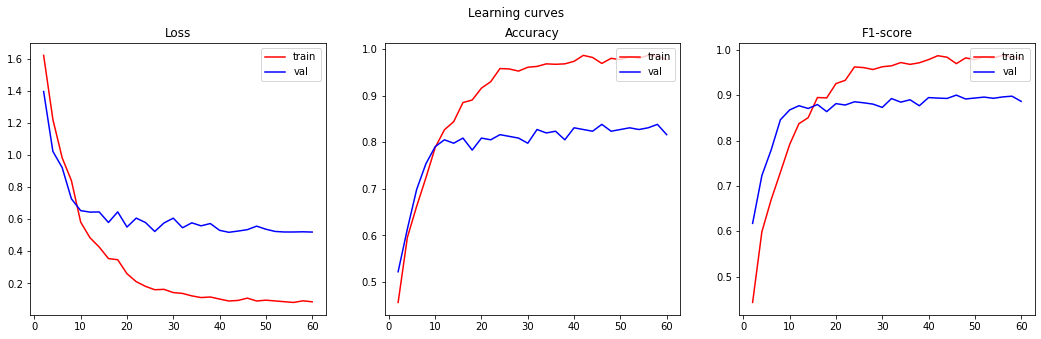

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Learning curves")
axs[0].plot(x, train_history['loss'], 'r', label = 'train')
axs[0].plot(x, val_history['loss'], 'b', label = 'val')
axs[0].legend(loc="upper right")
axs[0].set_title("Loss")
axs[1].plot(x, train_history['accuracy'], 'r', label = 'train')
axs[1].plot(x, val_history['accuracy'], 'b', label = 'val')
axs[1].legend(loc="upper right")
axs[1].set_title("Accuracy")
axs[2].plot(x, train_history['f1'], 'r', label = 'train')
axs[2].plot(x, val_history['f1'], 'b', label = 'val')
axs[2].legend(loc="upper right")
axs[2].set_title("F1-score")
None

По графику видно, что примерно на 46 эпохе начинается плато, возьмем ее за лучшую модель.

In [22]:
# torch.cuda.empty_cache() 
# model.load_state_dict('vgg_weights/best_weights_46.pkl')

### Test and metrics

In [23]:
val_f1 = val_history['f1'][17]
val_acc = val_history['accuracy'][17]
print(f'Val f1: {val_f1}')
print(f'Val accuracy: {val_acc}')

Val f1: 0.8900563488798783
Val accuracy: 0.8235294117647058


## ResNet

In [13]:
import torchvision.models as models
resnet18 = models.resnet18(weights=None)
resnet18.apply(weights_init_uniform)
resnet18.to(device)
None

In [14]:
train_params = {
    'start_lr': 1e-5,
    'scheduler_step_size': 30,
    'scheduler_gamma': 0.5,
    'num_epochs': 60,
    'every_epoch': 2,
}

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, resnet18.parameters()), 
                          lr=train_params['start_lr'])

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, 
                                       step_size=train_params['scheduler_step_size'], 
                                       gamma=train_params['scheduler_gamma'])
loss_func = nn.CrossEntropyLoss()

resnet18, train_history, val_history = train_model(resnet18, 'resnet_weights', optimizer_ft, 
                                                loss_func, exp_lr_scheduler, 
                                                num_epochs=train_params['num_epochs'],
                                                every_epoch = train_params['every_epoch'])

/home/user/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch 1/60
----------
PHASE: TRAIN
LR 1e-05


100%|██████████| 137/137 [00:15<00:00,  8.79it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.17it/s]


Epoch 2/60
----------
PHASE: TRAIN
LR 1e-05


100%|██████████| 137/137 [00:15<00:00,  8.62it/s]


train_loss:  4.141209082011759
train_accuracy:  0.2728102189781022
train_f1:  0.26608446298227323
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.91it/s]


val_loss:  3.2983745336532593
val_accuracy:  0.3639705882352941
val_f1:  0.48192789644995526
---------------------------
Epoch 3/60
----------
PHASE: TRAIN
LR 1e-05


100%|██████████| 137/137 [00:15<00:00,  8.73it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.10it/s]


Epoch 4/60
----------
PHASE: TRAIN
LR 1e-05


100%|██████████| 137/137 [00:15<00:00,  8.82it/s]


train_loss:  2.461871315963077
train_accuracy:  0.4124087591240876
train_f1:  0.43132603406326014
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.00it/s]


val_loss:  2.0978574117316917
val_accuracy:  0.47058823529411764
val_f1:  0.5943695193695194
---------------------------
Epoch 5/60
----------
PHASE: TRAIN
LR 1e-05


100%|██████████| 137/137 [00:15<00:00,  9.00it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.84it/s]


Epoch 6/60
----------
PHASE: TRAIN
LR 1e-05


100%|██████████| 137/137 [00:15<00:00,  8.86it/s]


train_loss:  1.9195943670551272
train_accuracy:  0.43613138686131386
train_f1:  0.44635036496350367
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.92it/s]


val_loss:  1.7218784401193261
val_accuracy:  0.5
val_f1:  0.6242885586635587
---------------------------
Epoch 7/60
----------
PHASE: TRAIN
LR 1e-05


100%|██████████| 137/137 [00:16<00:00,  8.50it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.88it/s]


Epoch 8/60
----------
PHASE: TRAIN
LR 1e-05


100%|██████████| 137/137 [00:15<00:00,  8.82it/s]


train_loss:  1.6496607770014853
train_accuracy:  0.46806569343065696
train_f1:  0.4763034410844631
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.85it/s]


val_loss:  1.5658875596983468
val_accuracy:  0.5183823529411765
val_f1:  0.6401436798495622
---------------------------
Epoch 9/60
----------
PHASE: TRAIN
LR 1e-05


100%|██████████| 137/137 [00:15<00:00,  8.88it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.19it/s]


Epoch 10/60
----------
PHASE: TRAIN
LR 1e-05


100%|██████████| 137/137 [00:14<00:00,  9.25it/s]


train_loss:  1.5429143588038257
train_accuracy:  0.5082116788321168
train_f1:  0.5285236357316649
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.88it/s]


val_loss:  1.4909731092698433
val_accuracy:  0.5330882352941176
val_f1:  0.6642142171553939
---------------------------
Epoch 11/60
----------
PHASE: TRAIN
LR 1e-05


100%|██████████| 137/137 [00:15<00:00,  9.13it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.95it/s]


Epoch 12/60
----------
PHASE: TRAIN
LR 1e-05


100%|██████████| 137/137 [00:16<00:00,  8.51it/s]


train_loss:  1.434213987667195
train_accuracy:  0.5392335766423357
train_f1:  0.5538321167883211
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.05it/s]


val_loss:  1.4209976853693234
val_accuracy:  0.5772058823529411
val_f1:  0.7030678471854943
---------------------------
Epoch 13/60
----------
PHASE: TRAIN
LR 1e-05


100%|██████████| 137/137 [00:14<00:00,  9.33it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.11it/s]


Epoch 14/60
----------
PHASE: TRAIN
LR 1e-05


100%|██████████| 137/137 [00:15<00:00,  9.04it/s]


train_loss:  1.3061700158745704
train_accuracy:  0.5593065693430657
train_f1:  0.5784671532846712
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.95it/s]


val_loss:  1.3351993430542815
val_accuracy:  0.5808823529411765
val_f1:  0.7063515120500418
---------------------------
Epoch 15/60
----------
PHASE: TRAIN
LR 1e-05


100%|██████████| 137/137 [00:15<00:00,  8.65it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.18it/s]


Epoch 16/60
----------
PHASE: TRAIN
LR 1e-05


100%|██████████| 137/137 [00:15<00:00,  8.93it/s]


train_loss:  1.2676209920514239
train_accuracy:  0.5784671532846716
train_f1:  0.6017857142857144
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.23it/s]


val_loss:  1.2818668245830958
val_accuracy:  0.5845588235294118
val_f1:  0.7115784746299452
---------------------------
Epoch 17/60
----------
PHASE: TRAIN
LR 1e-05


100%|██████████| 137/137 [00:14<00:00,  9.17it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.83it/s]


Epoch 18/60
----------
PHASE: TRAIN
LR 1e-05


100%|██████████| 137/137 [00:16<00:00,  8.51it/s]


train_loss:  1.2246930262033087
train_accuracy:  0.5958029197080292
train_f1:  0.613773027459159
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.94it/s]


val_loss:  1.3279906362021232
val_accuracy:  0.5735294117647058
val_f1:  0.6896934968626146
---------------------------
Epoch 19/60
----------
PHASE: TRAIN
LR 1e-05


100%|██████████| 137/137 [00:15<00:00,  8.95it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.89it/s]


Epoch 20/60
----------
PHASE: TRAIN
LR 1e-05


100%|██████████| 137/137 [00:15<00:00,  8.68it/s]


train_loss:  1.1752387109029032
train_accuracy:  0.5994525547445255
train_f1:  0.6239659367396594
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.94it/s]


val_loss:  1.2821484308908968
val_accuracy:  0.5772058823529411
val_f1:  0.7057563147636678
---------------------------
Epoch 21/60
----------
PHASE: TRAIN
LR 1e-05


100%|██████████| 137/137 [00:15<00:00,  8.76it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.95it/s]


Epoch 22/60
----------
PHASE: TRAIN
LR 1e-05


100%|██████████| 137/137 [00:14<00:00,  9.36it/s]


train_loss:  1.1595182040311995
train_accuracy:  0.614963503649635
train_f1:  0.6391293013555783
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.03it/s]


val_loss:  1.1878199024701162
val_accuracy:  0.5955882352941176
val_f1:  0.7120879120879122
---------------------------
Epoch 23/60
----------
PHASE: TRAIN
LR 1e-05


100%|██████████| 137/137 [00:15<00:00,  8.71it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.90it/s]


Epoch 24/60
----------
PHASE: TRAIN
LR 1e-05


100%|██████████| 137/137 [00:14<00:00,  9.21it/s]


train_loss:  1.0903437914204424
train_accuracy:  0.6322992700729927
train_f1:  0.655170316301703
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.02it/s]


val_loss:  1.1363486164413832
val_accuracy:  0.6397058823529411
val_f1:  0.7515646526675939
---------------------------
Epoch 25/60
----------
PHASE: TRAIN
LR 1e-05


100%|██████████| 137/137 [00:15<00:00,  9.12it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.75it/s]


Epoch 26/60
----------
PHASE: TRAIN
LR 1e-05


100%|██████████| 137/137 [00:14<00:00,  9.26it/s]


train_loss:  0.9839562042786257
train_accuracy:  0.6779197080291971
train_f1:  0.6985249391727494
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.03it/s]


val_loss:  1.082748670678805
val_accuracy:  0.6544117647058824
val_f1:  0.7594599436511202
---------------------------
Epoch 27/60
----------
PHASE: TRAIN
LR 1e-05


100%|██████████| 137/137 [00:15<00:00,  8.87it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.01it/s]


Epoch 28/60
----------
PHASE: TRAIN
LR 1e-05


100%|██████████| 137/137 [00:15<00:00,  9.05it/s]


train_loss:  0.9503740407254574
train_accuracy:  0.6852189781021898
train_f1:  0.7019377824122351
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.12it/s]


val_loss:  1.0969452392309904
val_accuracy:  0.6286764705882353
val_f1:  0.7316140354743296
---------------------------
Epoch 29/60
----------
PHASE: TRAIN
LR 1e-05


100%|██████████| 137/137 [00:16<00:00,  8.49it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.89it/s]


Epoch 30/60
----------
PHASE: TRAIN
LR 5e-06


100%|██████████| 137/137 [00:15<00:00,  8.78it/s]


train_loss:  0.920775653998347
train_accuracy:  0.697992700729927
train_f1:  0.7248435870698644
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.87it/s]


val_loss:  1.0788519431234282
val_accuracy:  0.6507352941176471
val_f1:  0.7655714587699883
---------------------------
Epoch 31/60
----------
PHASE: TRAIN
LR 5e-06


100%|██████████| 137/137 [00:15<00:00,  8.76it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.85it/s]


Epoch 32/60
----------
PHASE: TRAIN
LR 5e-06


100%|██████████| 137/137 [00:15<00:00,  9.11it/s]


train_loss:  0.8821536341722864
train_accuracy:  0.7198905109489051
train_f1:  0.7398375043448039
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.97it/s]


val_loss:  1.0378791797522675
val_accuracy:  0.6544117647058824
val_f1:  0.7681633929795696
---------------------------
Epoch 33/60
----------
PHASE: TRAIN
LR 5e-06


100%|██████████| 137/137 [00:14<00:00,  9.47it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.07it/s]


Epoch 34/60
----------
PHASE: TRAIN
LR 5e-06


100%|██████████| 137/137 [00:15<00:00,  8.71it/s]


train_loss:  0.8602106551619342
train_accuracy:  0.7144160583941606
train_f1:  0.7327815432742442
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.97it/s]


val_loss:  1.0419854360139544
val_accuracy:  0.6654411764705882
val_f1:  0.7693893116687235
---------------------------
Epoch 35/60
----------
PHASE: TRAIN
LR 5e-06


100%|██████████| 137/137 [00:16<00:00,  8.33it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.37it/s]


Epoch 36/60
----------
PHASE: TRAIN
LR 5e-06


100%|██████████| 137/137 [00:15<00:00,  8.66it/s]


train_loss:  0.8501288861471371
train_accuracy:  0.7125912408759124
train_f1:  0.7373783454987832
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.00it/s]


val_loss:  1.0280455560971271
val_accuracy:  0.6507352941176471
val_f1:  0.76519962880257
---------------------------
Epoch 37/60
----------
PHASE: TRAIN
LR 5e-06


100%|██████████| 137/137 [00:14<00:00,  9.46it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.00it/s]


Epoch 38/60
----------
PHASE: TRAIN
LR 5e-06


100%|██████████| 137/137 [00:15<00:00,  8.81it/s]


train_loss:  0.8256123873004078
train_accuracy:  0.7262773722627737
train_f1:  0.7475625651720543
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.82it/s]


val_loss:  1.0289341938709293
val_accuracy:  0.6433823529411765
val_f1:  0.7600589361618775
---------------------------
Epoch 39/60
----------
PHASE: TRAIN
LR 5e-06


100%|██████████| 137/137 [00:15<00:00,  9.05it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.77it/s]


Epoch 40/60
----------
PHASE: TRAIN
LR 5e-06


100%|██████████| 137/137 [00:15<00:00,  8.97it/s]


train_loss:  0.8076809840480776
train_accuracy:  0.7436131386861314
train_f1:  0.762460896767466
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.08it/s]


val_loss:  0.9580144277116394
val_accuracy:  0.6911764705882353
val_f1:  0.7975500194250197
---------------------------
Epoch 41/60
----------
PHASE: TRAIN
LR 5e-06


100%|██████████| 137/137 [00:15<00:00,  9.11it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.08it/s]


Epoch 42/60
----------
PHASE: TRAIN
LR 5e-06


100%|██████████| 137/137 [00:15<00:00,  8.67it/s]


train_loss:  0.8183934239357927
train_accuracy:  0.7290145985401459
train_f1:  0.7548357664233575
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.80it/s]


val_loss:  0.9698436447857496
val_accuracy:  0.6801470588235294
val_f1:  0.7927647719927134
---------------------------
Epoch 43/60
----------
PHASE: TRAIN
LR 5e-06


100%|██████████| 137/137 [00:16<00:00,  8.26it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.91it/s]


Epoch 44/60
----------
PHASE: TRAIN
LR 5e-06


100%|██████████| 137/137 [00:15<00:00,  8.92it/s]


train_loss:  0.7942051840742139
train_accuracy:  0.75
train_f1:  0.7691214807090722
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.88it/s]


val_loss:  0.9062040082096834
val_accuracy:  0.6985294117647058
val_f1:  0.8039366270983921
---------------------------
Epoch 45/60
----------
PHASE: TRAIN
LR 5e-06


100%|██████████| 137/137 [00:15<00:00,  8.78it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.83it/s]


Epoch 46/60
----------
PHASE: TRAIN
LR 5e-06


100%|██████████| 137/137 [00:15<00:00,  9.04it/s]


train_loss:  0.8066414155229165
train_accuracy:  0.739963503649635
train_f1:  0.76406340516742
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.98it/s]


val_loss:  0.9604227829738247
val_accuracy:  0.6948529411764706
val_f1:  0.8024563263533855
---------------------------
Epoch 47/60
----------
PHASE: TRAIN
LR 5e-06


100%|██████████| 137/137 [00:16<00:00,  8.48it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.03it/s]


Epoch 48/60
----------
PHASE: TRAIN
LR 5e-06


100%|██████████| 137/137 [00:15<00:00,  8.75it/s]


train_loss:  0.7462302928205824
train_accuracy:  0.7536496350364964
train_f1:  0.7708680917622525
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.95it/s]


val_loss:  0.9103416188907645
val_accuracy:  0.7205882352941176
val_f1:  0.8221068963716025
---------------------------
Epoch 49/60
----------
PHASE: TRAIN
LR 5e-06


100%|██████████| 137/137 [00:15<00:00,  9.09it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.70it/s]


Epoch 50/60
----------
PHASE: TRAIN
LR 5e-06


100%|██████████| 137/137 [00:15<00:00,  8.78it/s]


train_loss:  0.7430732056607295
train_accuracy:  0.7609489051094891
train_f1:  0.7863616614529025
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.85it/s]


val_loss:  0.9208469860502245
val_accuracy:  0.6911764705882353
val_f1:  0.7972842108871523
---------------------------
Epoch 51/60
----------
PHASE: TRAIN
LR 5e-06


100%|██████████| 137/137 [00:15<00:00,  9.00it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.00it/s]


Epoch 52/60
----------
PHASE: TRAIN
LR 5e-06


100%|██████████| 137/137 [00:15<00:00,  8.68it/s]


train_loss:  0.7072346983817372
train_accuracy:  0.7655109489051095
train_f1:  0.7835636079249217
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.95it/s]


val_loss:  0.8822492328198517
val_accuracy:  0.7058823529411765
val_f1:  0.8116101627131042
---------------------------
Epoch 53/60
----------
PHASE: TRAIN
LR 5e-06


100%|██████████| 137/137 [00:15<00:00,  8.91it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.03it/s]


Epoch 54/60
----------
PHASE: TRAIN
LR 5e-06


100%|██████████| 137/137 [00:15<00:00,  8.93it/s]


train_loss:  0.7404142470255385
train_accuracy:  0.7609489051094891
train_f1:  0.784454292665971
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.87it/s]


val_loss:  0.9311241893755162
val_accuracy:  0.6875
val_f1:  0.7969413756178463
---------------------------
Epoch 55/60
----------
PHASE: TRAIN
LR 5e-06


100%|██████████| 137/137 [00:15<00:00,  9.04it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.91it/s]


Epoch 56/60
----------
PHASE: TRAIN
LR 5e-06


100%|██████████| 137/137 [00:14<00:00,  9.33it/s]


train_loss:  0.6934971982327691
train_accuracy:  0.7864963503649635
train_f1:  0.8108185610010428
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.80it/s]


val_loss:  0.9358630809549462
val_accuracy:  0.6875
val_f1:  0.7922975717093366
---------------------------
Epoch 57/60
----------
PHASE: TRAIN
LR 5e-06


100%|██████████| 137/137 [00:15<00:00,  8.78it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.87it/s]


Epoch 58/60
----------
PHASE: TRAIN
LR 5e-06


100%|██████████| 137/137 [00:14<00:00,  9.67it/s]


train_loss:  0.6595278287673518
train_accuracy:  0.801094890510949
train_f1:  0.8198514077163717
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.00it/s]


val_loss:  0.8617151107036454
val_accuracy:  0.7022058823529411
val_f1:  0.8097375255463493
---------------------------
Epoch 59/60
----------
PHASE: TRAIN
LR 5e-06


100%|██████████| 137/137 [00:16<00:00,  8.49it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.77it/s]


Epoch 60/60
----------
PHASE: TRAIN
LR 2.5e-06


100%|██████████| 137/137 [00:16<00:00,  8.56it/s]


train_loss:  0.6623027522633546
train_accuracy:  0.7928832116788321
train_f1:  0.8192301007994439
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.06it/s]


val_loss:  0.8917186202974442
val_accuracy:  0.7279411764705882
val_f1:  0.8262250821074353
---------------------------


In [15]:
x = np.arange(1, 31)*2

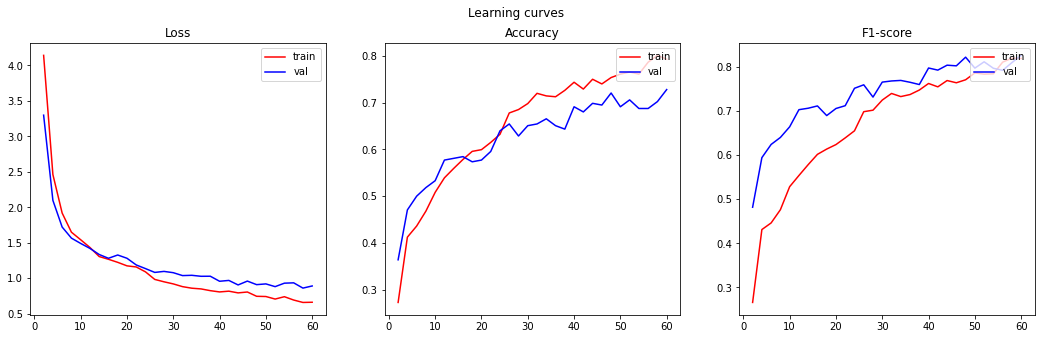

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Learning curves")
axs[0].plot(x, train_history['loss'], 'r', label = 'train')
axs[0].plot(x, val_history['loss'], 'b', label = 'val')
axs[0].legend(loc="upper right")
axs[0].set_title("Loss")
axs[1].plot(x, train_history['accuracy'], 'r', label = 'train')
axs[1].plot(x, val_history['accuracy'], 'b', label = 'val')
axs[1].legend(loc="upper right")
axs[1].set_title("Accuracy")
axs[2].plot(x, train_history['f1'], 'r', label = 'train')
axs[2].plot(x, val_history['f1'], 'b', label = 'val')
axs[2].legend(loc="upper right")
axs[2].set_title("F1-score")
None

Модель, возможно, не доучилась, но на данном этапе она явно уступает VGG16

## EfficientNet

In [13]:
effnet = models.efficientnet_b0(weights=None)
effnet.apply(weights_init_uniform)
effnet.to(device)
None

In [14]:
train_params = {
    'start_lr': 1e-4,
    'scheduler_step_size': 20,
    'scheduler_gamma': 0.5,
    'num_epochs': 60,
    'every_epoch': 2,
}

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, effnet.parameters()), 
                          lr=train_params['start_lr'])

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, 
                                       step_size=train_params['scheduler_step_size'], 
                                       gamma=train_params['scheduler_gamma'])
loss_func = nn.CrossEntropyLoss()

effnet, train_history, val_history = train_model(effnet, 'effnet_weights', optimizer_ft, 
                                                loss_func, exp_lr_scheduler, 
                                                num_epochs=train_params['num_epochs'],
                                                every_epoch = train_params['every_epoch'])

/home/user/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch 1/60
----------
PHASE: TRAIN
LR 0.0001


100%|██████████| 137/137 [00:17<00:00,  7.98it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.11it/s]


Epoch 2/60
----------
PHASE: TRAIN
LR 0.0001


100%|██████████| 137/137 [00:15<00:00,  8.68it/s]


train_loss:  2.394498377820871
train_accuracy:  0.23266423357664234
train_f1:  0.2316605839416058
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.97it/s]


val_loss:  2.4600756939719703
val_accuracy:  0.3088235294117647
val_f1:  0.41950127078803545
---------------------------
Epoch 3/60
----------
PHASE: TRAIN
LR 0.0001


100%|██████████| 137/137 [00:16<00:00,  8.51it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.91it/s]


Epoch 4/60
----------
PHASE: TRAIN
LR 0.0001


100%|██████████| 137/137 [00:15<00:00,  8.99it/s]


train_loss:  1.8784377174655886
train_accuracy:  0.33211678832116787
train_f1:  0.34131473757386166
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.96it/s]


val_loss:  1.8715333079590517
val_accuracy:  0.38235294117647056
val_f1:  0.5075424779468896
---------------------------
Epoch 5/60
----------
PHASE: TRAIN
LR 0.0001


100%|██████████| 137/137 [00:15<00:00,  8.89it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.78it/s]


Epoch 6/60
----------
PHASE: TRAIN
LR 0.0001


100%|██████████| 137/137 [00:15<00:00,  8.68it/s]


train_loss:  1.666062306313619
train_accuracy:  0.40693430656934304
train_f1:  0.42360097323600965
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.09it/s]


val_loss:  1.5968892280669773
val_accuracy:  0.4632352941176471
val_f1:  0.5668198427389604
---------------------------
Epoch 7/60
----------
PHASE: TRAIN
LR 0.0001


100%|██████████| 137/137 [00:15<00:00,  8.85it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.00it/s]


Epoch 8/60
----------
PHASE: TRAIN
LR 0.0001


100%|██████████| 137/137 [00:15<00:00,  8.82it/s]


train_loss:  1.4533443703268567
train_accuracy:  0.46441605839416056
train_f1:  0.4837591240875913
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.17it/s]


val_loss:  1.2373452542678398
val_accuracy:  0.5588235294117647
val_f1:  0.6731981662128724
---------------------------
Epoch 9/60
----------
PHASE: TRAIN
LR 0.0001


100%|██████████| 137/137 [00:15<00:00,  8.67it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.09it/s]


Epoch 10/60
----------
PHASE: TRAIN
LR 0.0001


100%|██████████| 137/137 [00:16<00:00,  8.54it/s]


train_loss:  1.3592259857776392
train_accuracy:  0.5109489051094891
train_f1:  0.5235401459854012
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.71it/s]


val_loss:  1.0900509587543852
val_accuracy:  0.6397058823529411
val_f1:  0.7422026910997501
---------------------------
Epoch 11/60
----------
PHASE: TRAIN
LR 0.0001


100%|██████████| 137/137 [00:16<00:00,  8.48it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.83it/s]


Epoch 12/60
----------
PHASE: TRAIN
LR 0.0001


100%|██████████| 137/137 [00:16<00:00,  8.54it/s]


train_loss:  1.1550396023875606
train_accuracy:  0.5875912408759124
train_f1:  0.6100625651720544
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.04it/s]


val_loss:  0.9582249268012888
val_accuracy:  0.6727941176470589
val_f1:  0.7763207380854441
---------------------------
Epoch 13/60
----------
PHASE: TRAIN
LR 0.0001


100%|██████████| 137/137 [00:15<00:00,  8.77it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.01it/s]


Epoch 14/60
----------
PHASE: TRAIN
LR 0.0001


100%|██████████| 137/137 [00:15<00:00,  8.90it/s]


train_loss:  1.078846069147987
train_accuracy:  0.6021897810218978
train_f1:  0.6264424748001391
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.15it/s]


val_loss:  0.9863503858008805
val_accuracy:  0.6764705882352942
val_f1:  0.7738026679203152
---------------------------
Epoch 15/60
----------
PHASE: TRAIN
LR 0.0001


100%|██████████| 137/137 [00:15<00:00,  9.02it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.01it/s]


Epoch 16/60
----------
PHASE: TRAIN
LR 0.0001


100%|██████████| 137/137 [00:15<00:00,  8.89it/s]


train_loss:  0.8975735867980623
train_accuracy:  0.6843065693430657
train_f1:  0.7057872784150153
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.93it/s]


val_loss:  0.7720541219391367
val_accuracy:  0.7242647058823529
val_f1:  0.8151579629520808
---------------------------
Epoch 17/60
----------
PHASE: TRAIN
LR 0.0001


100%|██████████| 137/137 [00:15<00:00,  8.77it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.14it/s]


Epoch 18/60
----------
PHASE: TRAIN
LR 0.0001


100%|██████████| 137/137 [00:14<00:00,  9.37it/s]


train_loss:  0.8486959229420571
train_accuracy:  0.708029197080292
train_f1:  0.7332725060827253
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.04it/s]


val_loss:  0.7597109179341179
val_accuracy:  0.7316176470588235
val_f1:  0.8150655308743547
---------------------------
Epoch 19/60
----------
PHASE: TRAIN
LR 0.0001


100%|██████████| 137/137 [00:14<00:00,  9.26it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.92it/s]


Epoch 20/60
----------
PHASE: TRAIN
LR 5e-05


100%|██████████| 137/137 [00:15<00:00,  8.92it/s]


train_loss:  0.6685405199545144
train_accuracy:  0.7627737226277372
train_f1:  0.7838460201598889
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.89it/s]


val_loss:  0.6857374723014587
val_accuracy:  0.7757352941176471
val_f1:  0.8527940197057846
---------------------------
Epoch 21/60
----------
PHASE: TRAIN
LR 5e-05


100%|██████████| 137/137 [00:15<00:00,  8.63it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.18it/s]


Epoch 22/60
----------
PHASE: TRAIN
LR 5e-05


100%|██████████| 137/137 [00:15<00:00,  9.04it/s]


train_loss:  0.6068151382743007
train_accuracy:  0.8074817518248175
train_f1:  0.8313825165102539
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.06it/s]


val_loss:  0.6210526572540402
val_accuracy:  0.7867647058823529
val_f1:  0.862452580099639
---------------------------
Epoch 23/60
----------
PHASE: TRAIN
LR 5e-05


100%|██████████| 137/137 [00:15<00:00,  8.66it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.87it/s]


Epoch 24/60
----------
PHASE: TRAIN
LR 5e-05


100%|██████████| 137/137 [00:15<00:00,  8.73it/s]


train_loss:  0.5644405272102704
train_accuracy:  0.8129562043795621
train_f1:  0.8321689259645465
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.91it/s]


val_loss:  0.6523142660529736
val_accuracy:  0.7904411764705882
val_f1:  0.8613046267458033
---------------------------
Epoch 25/60
----------
PHASE: TRAIN
LR 5e-05


100%|██████████| 137/137 [00:14<00:00,  9.33it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.92it/s]


Epoch 26/60
----------
PHASE: TRAIN
LR 5e-05


100%|██████████| 137/137 [00:15<00:00,  8.93it/s]


train_loss:  0.4681999731237871
train_accuracy:  0.843065693430657
train_f1:  0.8640163364615921
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.07it/s]


val_loss:  0.5958729355034473
val_accuracy:  0.7830882352941176
val_f1:  0.8606237104398871
---------------------------
Epoch 27/60
----------
PHASE: TRAIN
LR 5e-05


100%|██████████| 137/137 [00:15<00:00,  8.87it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.93it/s]


Epoch 28/60
----------
PHASE: TRAIN
LR 5e-05


100%|██████████| 137/137 [00:15<00:00,  9.05it/s]


train_loss:  0.44933376249170653
train_accuracy:  0.8531021897810219
train_f1:  0.8775981925616964
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.94it/s]


val_loss:  0.5766491519547451
val_accuracy:  0.8125
val_f1:  0.8798453996983411
---------------------------
Epoch 29/60
----------
PHASE: TRAIN
LR 5e-05


100%|██████████| 137/137 [00:15<00:00,  8.72it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.00it/s]


Epoch 30/60
----------
PHASE: TRAIN
LR 5e-05


100%|██████████| 137/137 [00:16<00:00,  8.31it/s]


train_loss:  0.419538107693848
train_accuracy:  0.8695255474452555
train_f1:  0.8914233576642334
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.92it/s]


val_loss:  0.6377084730809335
val_accuracy:  0.7904411764705882
val_f1:  0.8679272116772119
---------------------------
Epoch 31/60
----------
PHASE: TRAIN
LR 5e-05


100%|██████████| 137/137 [00:15<00:00,  8.84it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.08it/s]


Epoch 32/60
----------
PHASE: TRAIN
LR 5e-05


100%|██████████| 137/137 [00:15<00:00,  8.81it/s]


train_loss:  0.3910643814988162
train_accuracy:  0.864963503649635
train_f1:  0.8873479318734793
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.82it/s]


val_loss:  0.5803049948093865
val_accuracy:  0.8198529411764706
val_f1:  0.8894203427291665
---------------------------
Epoch 33/60
----------
PHASE: TRAIN
LR 5e-05


100%|██████████| 137/137 [00:15<00:00,  9.05it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.93it/s]


Epoch 34/60
----------
PHASE: TRAIN
LR 5e-05


100%|██████████| 137/137 [00:15<00:00,  8.89it/s]


train_loss:  0.38905691994476493
train_accuracy:  0.8777372262773723
train_f1:  0.8980057351407715
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.89it/s]


val_loss:  0.5577907513155985
val_accuracy:  0.8125
val_f1:  0.885707756295992
---------------------------
Epoch 35/60
----------
PHASE: TRAIN
LR 5e-05


100%|██████████| 137/137 [00:14<00:00,  9.20it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.80it/s]


Epoch 36/60
----------
PHASE: TRAIN
LR 5e-05


100%|██████████| 137/137 [00:14<00:00,  9.15it/s]


train_loss:  0.32936860620975494
train_accuracy:  0.8895985401459854
train_f1:  0.9071385123392423
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.89it/s]


val_loss:  0.5140471714959645
val_accuracy:  0.8639705882352942
val_f1:  0.9169726515314752
---------------------------
Epoch 37/60
----------
PHASE: TRAIN
LR 5e-05


100%|██████████| 137/137 [00:15<00:00,  9.12it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.87it/s]


Epoch 38/60
----------
PHASE: TRAIN
LR 5e-05


100%|██████████| 137/137 [00:15<00:00,  8.99it/s]


train_loss:  0.3420879324748568
train_accuracy:  0.8941605839416058
train_f1:  0.9141510253736532
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.93it/s]


val_loss:  0.5983936535605394
val_accuracy:  0.8345588235294118
val_f1:  0.8948056028938384
---------------------------
Epoch 39/60
----------
PHASE: TRAIN
LR 5e-05


100%|██████████| 137/137 [00:15<00:00,  8.88it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.83it/s]


Epoch 40/60
----------
PHASE: TRAIN
LR 2.5e-05


100%|██████████| 137/137 [00:14<00:00,  9.32it/s]


train_loss:  0.24746541304337064
train_accuracy:  0.9315693430656934
train_f1:  0.9433307264511647
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.80it/s]


val_loss:  0.5322480572332793
val_accuracy:  0.8639705882352942
val_f1:  0.9165069407716468
---------------------------
Epoch 41/60
----------
PHASE: TRAIN
LR 2.5e-05


100%|██████████| 137/137 [00:15<00:00,  8.70it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.94it/s]


Epoch 42/60
----------
PHASE: TRAIN
LR 2.5e-05


100%|██████████| 137/137 [00:15<00:00,  8.83it/s]


train_loss:  0.2329555796731236
train_accuracy:  0.9306569343065694
train_f1:  0.9419273548835594
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.91it/s]


val_loss:  0.5283478983157479
val_accuracy:  0.8566176470588235
val_f1:  0.9141908744849924
---------------------------
Epoch 43/60
----------
PHASE: TRAIN
LR 2.5e-05


100%|██████████| 137/137 [00:15<00:00,  8.71it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.32it/s]


Epoch 44/60
----------
PHASE: TRAIN
LR 2.5e-05


100%|██████████| 137/137 [00:15<00:00,  8.89it/s]


train_loss:  0.2193169838266216
train_accuracy:  0.9343065693430657
train_f1:  0.9499000695168579
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.07it/s]


val_loss:  0.4942612673518905
val_accuracy:  0.8602941176470589
val_f1:  0.916764159043571
---------------------------
Epoch 45/60
----------
PHASE: TRAIN
LR 2.5e-05


100%|██████████| 137/137 [00:15<00:00,  8.65it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.86it/s]


Epoch 46/60
----------
PHASE: TRAIN
LR 2.5e-05


100%|██████████| 137/137 [00:15<00:00,  8.89it/s]


train_loss:  0.21317281675300676
train_accuracy:  0.9370437956204379
train_f1:  0.9520594369134516
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.92it/s]


val_loss:  0.4566594661985565
val_accuracy:  0.8492647058823529
val_f1:  0.9084870603252959
---------------------------
Epoch 47/60
----------
PHASE: TRAIN
LR 2.5e-05


100%|██████████| 137/137 [00:15<00:00,  8.87it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.94it/s]


Epoch 48/60
----------
PHASE: TRAIN
LR 2.5e-05


100%|██████████| 137/137 [00:15<00:00,  9.08it/s]


train_loss:  0.18011995282595175
train_accuracy:  0.9552919708029197
train_f1:  0.9660207391959218
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.17it/s]


val_loss:  0.49292728859290946
val_accuracy:  0.8492647058823529
val_f1:  0.9099108407931941
---------------------------
Epoch 49/60
----------
PHASE: TRAIN
LR 2.5e-05


100%|██████████| 137/137 [00:15<00:00,  8.60it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.02it/s]


Epoch 50/60
----------
PHASE: TRAIN
LR 2.5e-05


100%|██████████| 137/137 [00:15<00:00,  8.75it/s]


train_loss:  0.1741646094193315
train_accuracy:  0.9443430656934306
train_f1:  0.9536843934654158
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.74it/s]


val_loss:  0.5144129087018561
val_accuracy:  0.8345588235294118
val_f1:  0.8973272234301648
---------------------------
Epoch 51/60
----------
PHASE: TRAIN
LR 2.5e-05


100%|██████████| 137/137 [00:15<00:00,  8.87it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.94it/s]


Epoch 52/60
----------
PHASE: TRAIN
LR 2.5e-05


100%|██████████| 137/137 [00:15<00:00,  8.68it/s]


train_loss:  0.1877567027185629
train_accuracy:  0.9416058394160584
train_f1:  0.951655370177268
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.69it/s]


val_loss:  0.48634049650761024
val_accuracy:  0.8419117647058824
val_f1:  0.9041203077967785
---------------------------
Epoch 53/60
----------
PHASE: TRAIN
LR 2.5e-05


100%|██████████| 137/137 [00:16<00:00,  8.28it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.92it/s]


Epoch 54/60
----------
PHASE: TRAIN
LR 2.5e-05


100%|██████████| 137/137 [00:16<00:00,  8.34it/s]


train_loss:  0.1720879337865941
train_accuracy:  0.9516423357664233
train_f1:  0.9615542810798287
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.00it/s]


val_loss:  0.5179608372769401
val_accuracy:  0.8602941176470589
val_f1:  0.9169420448832216
---------------------------
Epoch 55/60
----------
PHASE: TRAIN
LR 2.5e-05


100%|██████████| 137/137 [00:15<00:00,  8.76it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.80it/s]


Epoch 56/60
----------
PHASE: TRAIN
LR 2.5e-05


100%|██████████| 137/137 [00:16<00:00,  8.34it/s]


train_loss:  0.15906861206401057
train_accuracy:  0.9461678832116789
train_f1:  0.9555222453945084
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.97it/s]


val_loss:  0.492658714277615
val_accuracy:  0.8419117647058824
val_f1:  0.9023880735277796
---------------------------
Epoch 57/60
----------
PHASE: TRAIN
LR 2.5e-05


100%|██████████| 137/137 [00:15<00:00,  8.86it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.87it/s]


Epoch 58/60
----------
PHASE: TRAIN
LR 2.5e-05


100%|██████████| 137/137 [00:16<00:00,  8.54it/s]


train_loss:  0.13056265904370995
train_accuracy:  0.9635036496350365
train_f1:  0.9718587069864446
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.02it/s]


val_loss:  0.47113278575938344
val_accuracy:  0.8345588235294118
val_f1:  0.9006162138515083
---------------------------
Epoch 59/60
----------
PHASE: TRAIN
LR 2.5e-05


100%|██████████| 137/137 [00:15<00:00,  9.01it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.84it/s]


Epoch 60/60
----------
PHASE: TRAIN
LR 1.25e-05


100%|██████████| 137/137 [00:15<00:00,  8.95it/s]


train_loss:  0.1547586192533265
train_accuracy:  0.9470802919708029
train_f1:  0.959758428919013
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.84it/s]

val_loss:  0.46795229953268597
val_accuracy:  0.8492647058823529
val_f1:  0.9118880302703835
---------------------------


In [15]:
x = np.arange(1, 31)*2

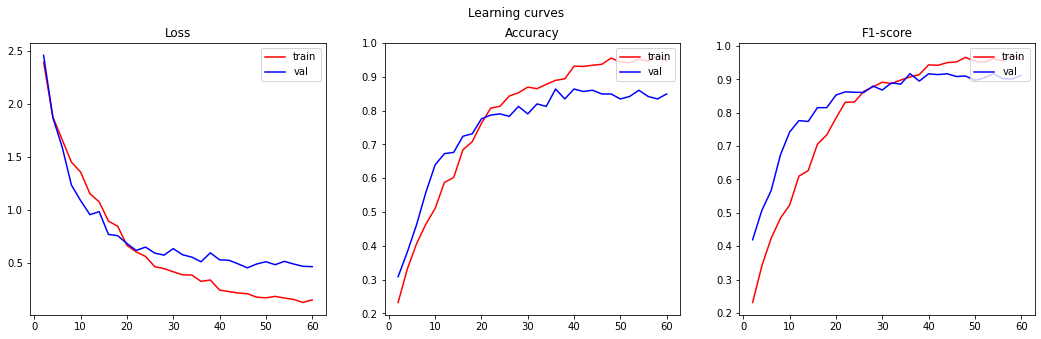

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Learning curves")
axs[0].plot(x, train_history['loss'], 'r', label = 'train')
axs[0].plot(x, val_history['loss'], 'b', label = 'val')
axs[0].legend(loc="upper right")
axs[0].set_title("Loss")
axs[1].plot(x, train_history['accuracy'], 'r', label = 'train')
axs[1].plot(x, val_history['accuracy'], 'b', label = 'val')
axs[1].legend(loc="upper right")
axs[1].set_title("Accuracy")
axs[2].plot(x, train_history['f1'], 'r', label = 'train')
axs[2].plot(x, val_history['f1'], 'b', label = 'val')
axs[2].legend(loc="upper right")
axs[2].set_title("F1-score")
None

Лучший скор на 42 этохе

In [17]:
val_f1 = val_history['f1'][21]
val_acc = val_history['accuracy'][21]
print(f'Val f1: {val_f1}')
print(f'Val accuracy: {val_acc}')

Val f1: 0.916764159043571
Val accuracy: 0.8602941176470589


### Summary

In [18]:
def find_true_pred_arrays(model, val_dataloader):
    model.eval()
    true = np.array([])
    pred = np.array([])

    for inputs, labels in tqdm(val_dataloader):
        inputs = inputs.float() 
        inputs = inputs.to(device)

        with torch.no_grad():
            outputs = model(inputs)

        true = np.append(true, labels.detach().numpy())
        pred = np.append(pred, torch.argmax(outputs, dim=1).cpu().detach().numpy())
    
    return true, pred

def plot_cf(cf):
    df_cm = pd.DataFrame(cf, range(10), range(10))
    # plt.figure(figsize=(10,7))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

    plt.show()

100%|██████████| 34/34 [00:04<00:00,  8.00it/s]


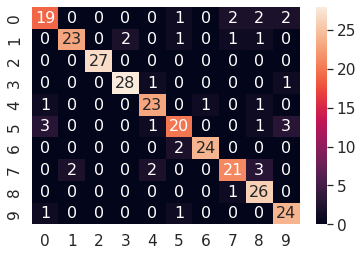

In [19]:
true, pred = find_true_pred_arrays(effnet, val_dataloader)
cf = confusion_matrix(true, pred)
plot_cf(cf)

In [20]:
print(classification_report(true, pred))

              precision    recall  f1-score   support

         0.0       0.79      0.73      0.76        26
         1.0       0.92      0.82      0.87        28
         2.0       1.00      1.00      1.00        27
         3.0       0.93      0.93      0.93        30
         4.0       0.85      0.88      0.87        26
         5.0       0.80      0.71      0.75        28
         6.0       0.96      0.92      0.94        26
         7.0       0.84      0.75      0.79        28
         8.0       0.76      0.96      0.85        27
         9.0       0.80      0.92      0.86        26

    accuracy                           0.86       272
   macro avg       0.87      0.86      0.86       272
weighted avg       0.87      0.86      0.86       272



### Выводы:
* Были обучены 3 модели (VGG16, ResNet18 и EfficientNet-B0)
* Лучшего качества достигла модель EfficientNet-B0
* Судя по высоким метрикам, почти диагональной матрице конфузии и отсутствию выпадающих классов в classification report, модель достаточно хорошо справляется с поставленной задачей классификации